In [2]:
#!pip install datasets
#!pip install transformers
#!pip install --upgrade torchvision
#!pip install tensorboard

In [3]:
import numpy as np
from datasets import load_dataset
import json
from transformers import ViTFeatureExtractor
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)
from torch.utils.data import DataLoader
import torch
from transformers import ViTForImageClassification
from transformers import file_utils
from transformers import TrainingArguments, Trainer
from datasets import load_metric
import time
from transformers import EarlyStoppingCallback, IntervalStrategy

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
train_ds = load_dataset("imagefolder", data_dir="./MelLong", split="train")

Resolving data files:   0%|          | 0/105843 [00:00<?, ?it/s]

Using custom data configuration default-a48d82573c99cd0c


Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /global/homes/k/ktub1999/.cache/huggingface/datasets/imagefolder/default-a48d82573c99cd0c/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


In [5]:
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.3)
train_val_ds = splits['train']
test_ds = splits['test']

splits = train_val_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']


In [6]:
print(len(train_ds),len(test_ds),len(val_ds))

66672 31749 7408


In [7]:
import os
cl=os.listdir('./SpeechCommand/SpeechCommands/speech_commands_v0.02/')
Class={}
cnt=0
for c in cl:
    Class[c]=cnt
    cnt+=1
Class

label2id=Class
id2label = {v: k for k, v in Class.items()}


with open("./MelLong/"+'id2label.json', 'w') as outfile:
    json.dump(id2label,outfile)
with open("./MelLong/"+'label2id.json', 'w') as outfile:
    json.dump(label2id,outfile)

In [8]:
train_ds

Dataset({
    features: ['image', 'classID', 'class'],
    num_rows: 66672
})

In [9]:
with open('./MelLong/label2id.json') as f:
    label2id = json.load(f)

with open('./MelLong/id2label.json') as f:
    id2label = json.load(f)

id2label = {int(key):value for key,value in id2label.items()}
id2label

{0: 'sheila',
 1: 'house',
 2: 'dog',
 3: 'README.md',
 4: 'validation_list.txt',
 5: '.DS_Store',
 6: 'go',
 7: 'right',
 8: 'bed',
 9: 'visual',
 10: 'LICENSE',
 11: 'stop',
 12: 'marvin',
 13: 'two',
 14: 'yes',
 15: 'seven',
 16: 'five',
 17: 'one',
 18: 'cat',
 19: 'follow',
 20: '_background_noise_',
 21: 'off',
 22: 'wow',
 23: 'tree',
 24: 'six',
 25: 'three',
 26: 'forward',
 27: 'up',
 28: 'on',
 29: 'happy',
 30: 'no',
 31: 'zero',
 32: 'learn',
 33: 'backward',
 34: 'down',
 35: 'testing_list.txt',
 36: 'eight',
 37: 'bird',
 38: 'nine',
 39: 'left',
 40: 'four'}

In [10]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

In [11]:
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

In [12]:
_train_transforms = Compose(
        [
            RandomResizedCrop(tuple(feature_extractor.size.values())),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(tuple(feature_extractor.size.values())),
            CenterCrop(tuple(feature_extractor.size.values())),
            ToTensor(),
            normalize,
        ]
    )

In [13]:
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [14]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [15]:
train_ds[:2]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=201x128 at 0x7F4D627E7220>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=192x128 at 0x7F4D627E72B0>],
 'classID': [26, 37],
 'class': ['forward', 'bird'],
 'pixel_values': [tensor([[[-0.4667, -0.4667, -0.4667,  ..., -0.4667, -0.4667, -0.4667],
           [-0.4667, -0.4667, -0.4667,  ..., -0.4667, -0.4667, -0.4667],
           [-0.4667, -0.4667, -0.4667,  ..., -0.4667, -0.4667, -0.4667],
           ...,
           [-0.4667, -0.4667, -0.4667,  ..., -0.4667, -0.4667, -0.4667],
           [-0.4667, -0.4667, -0.4667,  ..., -0.4667, -0.4667, -0.4667],
           [-0.4667, -0.4667, -0.4667,  ..., -0.4667, -0.4667, -0.4667]],
  
          [[-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
           [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
           [-0.9922, -0.9922, -0.9843,  ..., -0.9922, -0.9922, -0.9922],
           ...,
           [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.992

In [16]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["classID"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)


In [17]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [18]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=41,
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
metric_name = "accuracy"

args = TrainingArguments(
    f"train-UrbanSounds8k",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)



In [20]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/tmp/ipykernel_190992/371032755.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [21]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
)


In [22]:
#Using GPU
start_time = time.time()
trainer.train()
print('Total Time Taken (in sec):',time.time()-start_time)

/global/homes/k/ktub1999/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 66672
  Num Epochs = 50
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 333400
  Number of trainable parameters = 85830185


Epoch,Training Loss,Validation Loss,Accuracy
1,2.042500,1.603503,0.570059
2,1.619200,1.300986,0.622435
3,1.590100,0.987023,0.714093
4,1.428600,0.958647,0.719492
5,1.431600,0.832968,0.759719
6,1.324500,0.856786,0.751485
7,1.316000,0.734837,0.785367
8,1.253000,0.757638,0.782667
9,1.204400,0.700737,0.799406
10,1.187400,0.729173,0.795356


***** Running Evaluation *****
  Num examples = 7408
  Batch size = 4
Saving model checkpoint to train-UrbanSounds8k/checkpoint-6668
Configuration saved in train-UrbanSounds8k/checkpoint-6668/config.json
Model weights saved in train-UrbanSounds8k/checkpoint-6668/pytorch_model.bin
Image processor saved in train-UrbanSounds8k/checkpoint-6668/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 7408
  Batch size = 4
Saving model checkpoint to train-UrbanSounds8k/checkpoint-13336
Configuration saved in train-UrbanSounds8k/checkpoint-13336/config.json
Model weights saved in train-UrbanSounds8k/checkpoint-13336/pytorch_model.bin
Image processor saved in train-UrbanSounds8k/checkpoint-13336/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 7408
  Batch size = 4
Saving model checkpoint to train-UrbanSounds8k/checkpoint-20004
Configuration saved in train-UrbanSounds8k/checkpoint-20004/config.json
Model weights saved in train-UrbanSounds8k/checkpoint-20

  Num examples = 7408
  Batch size = 4
Saving model checkpoint to train-UrbanSounds8k/checkpoint-153364
Configuration saved in train-UrbanSounds8k/checkpoint-153364/config.json
Model weights saved in train-UrbanSounds8k/checkpoint-153364/pytorch_model.bin
Image processor saved in train-UrbanSounds8k/checkpoint-153364/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 7408
  Batch size = 4
Saving model checkpoint to train-UrbanSounds8k/checkpoint-160032
Configuration saved in train-UrbanSounds8k/checkpoint-160032/config.json
Model weights saved in train-UrbanSounds8k/checkpoint-160032/pytorch_model.bin
Image processor saved in train-UrbanSounds8k/checkpoint-160032/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 7408
  Batch size = 4
Saving model checkpoint to train-UrbanSounds8k/checkpoint-166700
Configuration saved in train-UrbanSounds8k/checkpoint-166700/config.json
Model weights saved in train-UrbanSounds8k/checkpoint-166700/pytorch_mode

***** Running Evaluation *****
  Num examples = 7408
  Batch size = 4
Saving model checkpoint to train-UrbanSounds8k/checkpoint-300060
Configuration saved in train-UrbanSounds8k/checkpoint-300060/config.json
Model weights saved in train-UrbanSounds8k/checkpoint-300060/pytorch_model.bin
Image processor saved in train-UrbanSounds8k/checkpoint-300060/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 7408
  Batch size = 4
Saving model checkpoint to train-UrbanSounds8k/checkpoint-306728
Configuration saved in train-UrbanSounds8k/checkpoint-306728/config.json
Model weights saved in train-UrbanSounds8k/checkpoint-306728/pytorch_model.bin
Image processor saved in train-UrbanSounds8k/checkpoint-306728/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 7408
  Batch size = 4
Saving model checkpoint to train-UrbanSounds8k/checkpoint-313396
Configuration saved in train-UrbanSounds8k/checkpoint-313396/config.json
Model weights saved in train-UrbanSounds8k

Total Time Taken (in sec): 45997.82528042793


In [23]:
outputs = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 31749
  Batch size = 4


In [24]:
print(outputs.metrics)

{'test_loss': 0.5537750124931335, 'test_accuracy': 0.868468298214117, 'test_runtime': 267.4921, 'test_samples_per_second': 118.691, 'test_steps_per_second': 29.676}


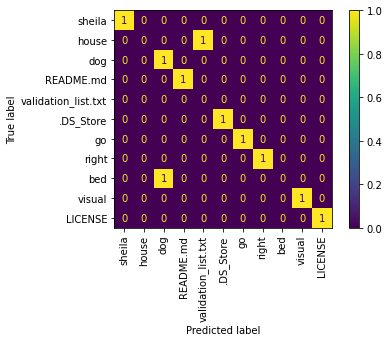

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels=[]
for i in range(11):
    labels.append(id2label[i])
# labels = id2label.values()

cm = confusion_matrix(y_true[:10], y_pred[:10])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90)


In [25]:
model.save_pretrained("./models/MelSpeachLongCommands")

Configuration saved in ./models/MelSpeachLongCommands/config.json
Model weights saved in ./models/MelSpeachLongCommands/pytorch_model.bin


In [39]:
import pandas as pd

AccDF= pd.read_csv("AccLengthy.csv")
TrainLoss = AccDF['TrainLoss']
ValidationLoss = AccDF['ValidationLoss']
Accuracy = AccDF['Accuracy']



[]

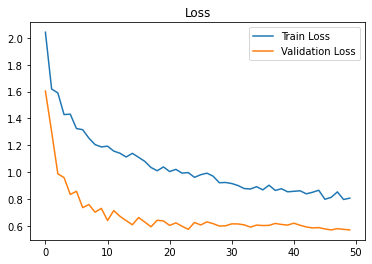

In [40]:
import matplotlib.pyplot as plt
f=plt.figure()
plt.title("Loss")
plt.plot(TrainLoss)
plt.plot(ValidationLoss)
plt.legend(["Train Loss","Validation Loss"])
plt.plot()

[]

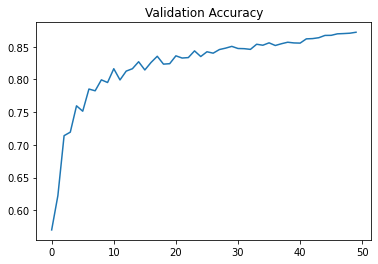

In [41]:
f = plt.figure()
plt.title("Validation Accuracy")
plt.plot(Accuracy)
plt.plot()

